# Simulate populations of neurons using NEST

In [1]:
from scipy.special import erf
import pylab
import numpy as np
import matplotlib.pyplot as plt
import nest

### Create populations

Each population is composed of 4,175 IAF neurons from which
80% are excitatory.

### Config

In [2]:
edict = {"I_e": 200.0, "tau_m": 20.0}
nest.CopyModel("iaf_psc_alpha", "exc_iaf_psc_alpha")
nest.SetDefaults("exc_iaf_psc_alpha", edict)

inh_cfg = {"I_e": 300.}

t_sim = 200.
t_wu = 100.

In [3]:
p1 = nest.Create("exc_iaf_psc_alpha", 4175)
p2 = nest.Create("exc_iaf_psc_alpha", 4175)
p3 = nest.Create("exc_iaf_psc_alpha", 4175)

In [4]:
# make 20% of the neurons inhibitory
for p in [p1,p2,p3]:
    for neuron in p[:835]:
        nest.SetStatus(neuron, inh_cfg)

In [5]:
# set random start Vs for all neurons
Vth=20.
Vrest=10.
V_range = Vrest + (Vth - Vrest)
for n1,n2,n3 in zip(p1,p2,p3):
    nest.SetStatus(n1, {"V_m": V_range * np.random.rand()})    
    nest.SetStatus(n2, {"V_m": V_range * np.random.rand()})
    nest.SetStatus(n3, {"V_m": V_range * np.random.rand()})    

In [6]:
nest.GetStatus(p1[0], ["V_m"])

((2.1987172200189633,),)

## First case: Connect neurons only within populations

### Connect neurons

Each neuron receives a synapse from 10% of randomly selected cells inside its population.




In [7]:
opt = np.arange(0, 4175)
for i, (n1,n2,n3) in enumerate(zip(p1,p2,p3)):
    
    # for each neuron randomize N / 10 ~ 417 neurons to connect to
    c1 = np.random.choice(opt, 417, replace=False)
    c2 = np.random.choice(opt, 417, replace=False)
    c3 = np.random.choice(opt, 417, replace=False)
     
    nest.Connect(p1[c1], n1)    
    nest.Connect(p2[c2], n2)
    nest.Connect(p3[c3], n3)

In [8]:
# TODO: add external poisson noise
pg_cfg = {"rate": 5.}
for i, (n1, n2, n3) in enumerate(zip(p1, p2, p3)):
    pg1 = nest.Create("poisson_generator", 1, pg_cfg)
    nest.Connect(pg1, n1)
    
    pg2 = nest.Create("poisson_generator", 1, pg_cfg)
    nest.Connect(pg2, n2)
    
    pg3 = nest.Create("poisson_generator", 1, pg_cfg)
    nest.Connect(pg3, n3)

### Simulate, measure and plot

In [9]:
# create a multimeter and a spike detector for each population
m1 = nest.Create("multimeter")
m2 = nest.Create("multimeter")
m3 = nest.Create("multimeter")

nest.SetStatus(m1, {"time_in_steps":True, "record_from":["V_m"]})
nest.SetStatus(m2, {"time_in_steps":True, "record_from":["V_m"]})
nest.SetStatus(m3, {"time_in_steps":True, "record_from":["V_m"]})

s1 = nest.Create("spike_detector")
s2 = nest.Create("spike_detector")
s3 = nest.Create("spike_detector")

In [10]:
# connect multimeters and spike detectors to the populations

nest.Connect(m1, p1)
nest.Connect(p1, s1)

nest.Connect(m2, p2)
nest.Connect(p2, s2)

nest.Connect(m3, p3)
nest.Connect(p3, s3)

In [11]:
nest.Simulate(t_wu)

In [12]:
plt.rcParams["figure.figsize"] = (20,5)

def plot_V(pops = []):
    
    for idx, multimeter in enumerate(pops):

        dmm = nest.GetStatus(multimeter)[0]
        Vms = dmm["events"]["V_m"]
        ts = dmm["events"]["times"]
        plt.plot(ts[np.arange(0,len(ts),4175)] / 10, Vms[np.arange(0,len(Vms),4175)])
    
    plt.title("Merged V_ms")
    plt.legend(["alhpa", "beta", "gamma"])
    plt.show()
        
    

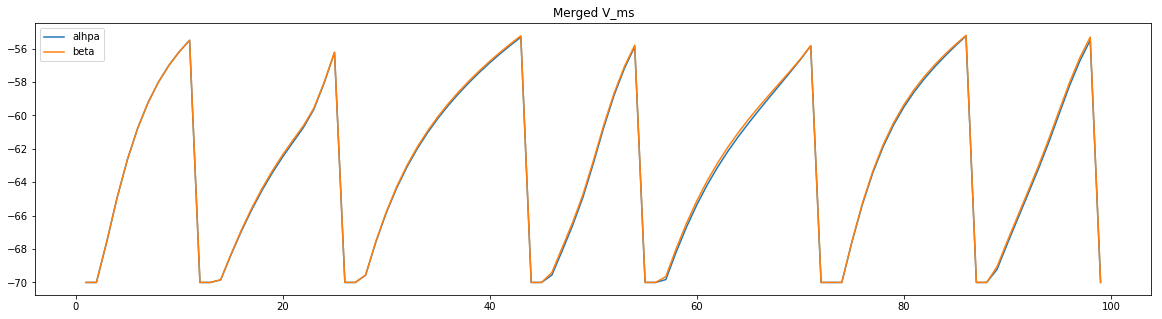

In [14]:
plot_V([m1, m3])

## Second case: Connect neurons to other populations

### Connect neurons

Each neuron also receives a synapse from 0.25% from the excitatory class of the neighboring populations.

In [15]:

opt = np.arange(835, 4175)
for n1,n2,n3 in zip(p1, p2, p3):
    # 4175 / 0.0025 ~ 10
    c21 = np.random.choice(opt, 10, replace=False)
    c23 = np.random.choice(opt, 10, replace=False)
    c12 = np.random.choice(opt, 10, replace=False)
    c32 = np.random.choice(opt, 10, replace=False)
     
    #for idx in connections:
    #    nest.Connect(p2[idx], neuron, syn_spec = {"weight":20.0})
    nest.Connect(p2[c21], n1) # p1 gets input from p2
    nest.Connect(p2[c23], n3) # p3 gets input from p2
    nest.Connect(p1[c12], n2) # "
    nest.Connect(p3[c32], n2) # "

In [16]:
nest.Simulate(t_sim)

In [21]:
from scipy.signal import correlate

def cross_correlate(m1, m2):
    dmm1 = nest.GetStatus(m1)[0]
    Vms1 = dmm1["events"]["V_m"]
    ts = dmm1["events"]["times"]
    
    dmm2 = nest.GetStatus(m1)[0]
    Vms2 = dmm1["events"]["V_m"]
    
    cor = correlate(Vms1, Vms2)
    plt.plot(ts, cor)

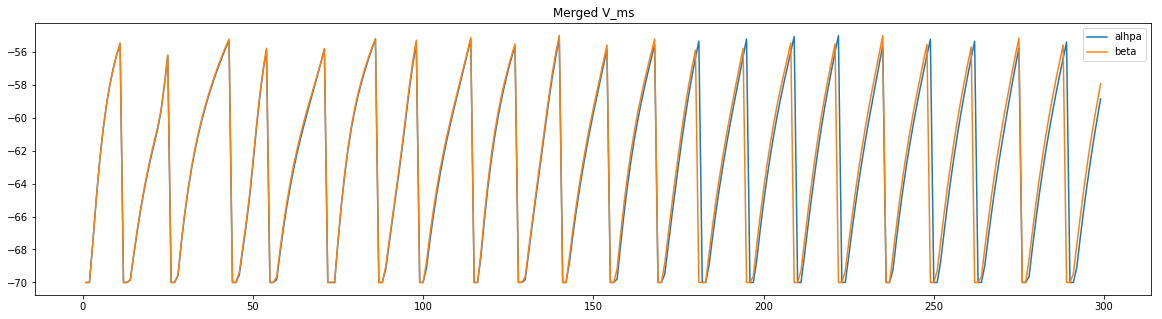

In [23]:
plot_V([m1, m3])
#cross_correlate(m1, m3)